In [17]:
import numpy as np
import matplotlib.pyplot as plt

(0.0, 10.0)

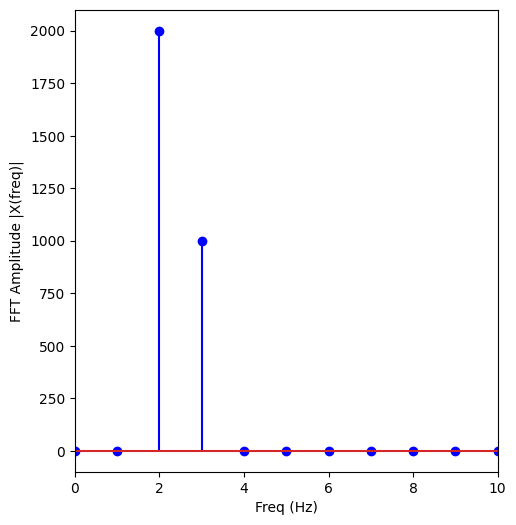

In [18]:
rate = 2000 #sampling rate
interval = 1.0/rate #sampling rate
t = np.arange(0, 1, interval) #time array

data_array_1 = 2*np.sin(2*np.pi*2*t) #sinusoid of frequency 2 Hz 
data_array_2 = np.sin(2*np.pi*3*t) # sinusoid of frequency 3 Hz

signal = data_array_1 + data_array_2 #syum of sinusoids

SIGNAL_transform = np.fft.fft(signal) #Fourier transform of signal
N = len(SIGNAL_transform) #number of data points in frequency domain
n = np.arange(N) #array of N
T = N/rate #sampling period
frequency = n/T #sampling frequency

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(frequency, np.abs(SIGNAL_transform), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)